In [1]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-24 19:30:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-24 19:30:12 (67.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

### Load the data

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-03-24 19:30:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 2607:f8b0:4023:c0b::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   131MB/s    in 15s     

2024-03-24 19:30:37 (103 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macaroni_and_cheese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_fries'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/greek_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/risotto'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheesecake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lasagna'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in '101_

In [5]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE= (224,224)
train_data_all_10_percent= tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode='categorical',
                                                                               image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode='categorical',
                                                               image_size=IMG_SIZE,
                                                               shuffle=False) #dont shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Feature extraction transfer learning with a pretrained EfficientNet model, then fine-tune

Steps to follow:
* Create a model checkpoint callback
* Create a data augmentation layer(may or may not work but need to check)
* Build a headless(no top layers) functional EfficientNetB0 backboned model
* compile model
* Feature extract for 5 full passes(5 epochs on train and validate on 15% of test data, to save epoch time)

In [6]:
#Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       save_weights_only=True, # save only the model weights
                                                       monitor='val_accuracy', # save the model weights which score the best validation accuracy
                                                       save_best_only=True) # only keep the best model weights on file (delete the rest)

In [7]:
# Create data augmentation layer to incorportae it into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
], name='data_augmentation')

In [8]:
#Setup base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation='softmax', name='output_layer')(x)
model=tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [10]:
#Compile
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 159s 626ms/step - loss: 3.3770 - accuracy: 0.2745 - val_loss: 2.4340 - val_accuracy: 0.4778
Epoch 2/5
237/237 [==============================] - 100s 417ms/step - loss: 2.2068 - accuracy: 0.4980 - val_loss: 2.0204 - val_accuracy: 0.5193
Epoch 3/5
237/237 [==============================] - 94s 396ms/step - loss: 1.8233 - accuracy: 0.5646 - val_loss: 1.8733 - val_accuracy: 0.5289
Epoch 4/5
237/237 [==============================] - 84s 353ms/step - loss: 1.6111 - accuracy: 0.6087 - val_loss: 1.7672 - val_accuracy: 0.5416
Epoch 5/5
237/237 [==============================] - 77s 325ms/step - loss: 1.4528 - accuracy: 0.6434 - val_loss: 1.7090 - val_accuracy: 0.5572


In [11]:
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 56s 70ms/step - loss: 1.5960 - accuracy: 0.5793


[1.5959593057632446, 0.5792871117591858]

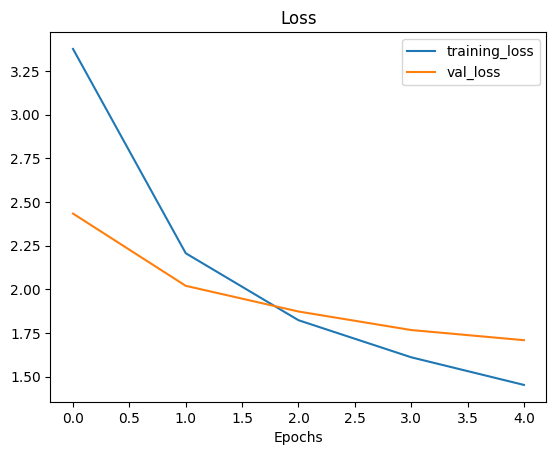

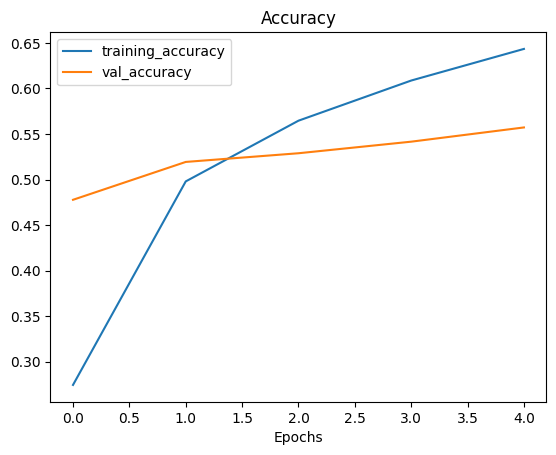

In [12]:
plot_loss_curves(history_all_classes_10_percent)

### Fine-tuning the model as the current one might be overfitting. (learning rate should be small in fine tuning)

In [13]:
# Unfreeze all layers in the base model
base_model.trainable=True

#Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [14]:
#Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [15]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [16]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [17]:
#Lets fine tune for 5 more epochs with these base model layers
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15*len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 79s 294ms/step - loss: 1.2051 - accuracy: 0.6866 - val_loss: 1.7141 - val_accuracy: 0.5479
Epoch 6/10
237/237 [==============================] - 69s 289ms/step - loss: 1.0919 - accuracy: 0.7094 - val_loss: 1.6796 - val_accuracy: 0.5572
Epoch 7/10
237/237 [==============================] - 61s 253ms/step - loss: 1.0144 - accuracy: 0.7278 - val_loss: 1.6961 - val_accuracy: 0.5511
Epoch 8/10
237/237 [==============================] - 58s 241ms/step - loss: 0.9462 - accuracy: 0.7447 - val_loss: 1.7062 - val_accuracy: 0.5485
Epoch 9/10
237/237 [==============================] - 57s 240ms/step - loss: 0.8923 - accuracy: 0.7620 - val_loss: 1.7038 - val_accuracy: 0.5453
Epoch 10/10
237/237 [==============================] - 53s 223ms/step - loss: 0.8219 - accuracy: 0.7795 - val_loss: 1.6941 - val_accuracy: 0.5527


In [18]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 55s 70ms/step - loss: 1.5128 - accuracy: 0.5996


[1.5128308534622192, 0.5996039509773254]

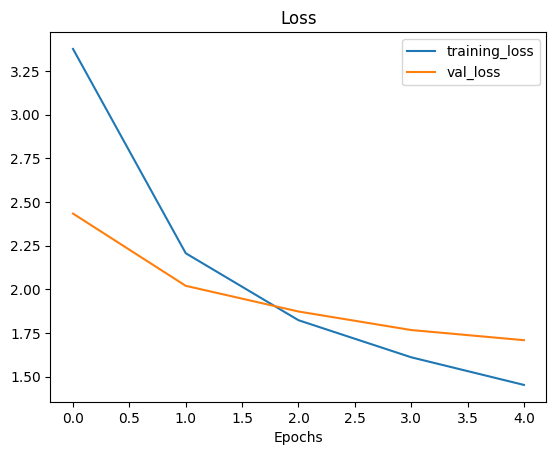

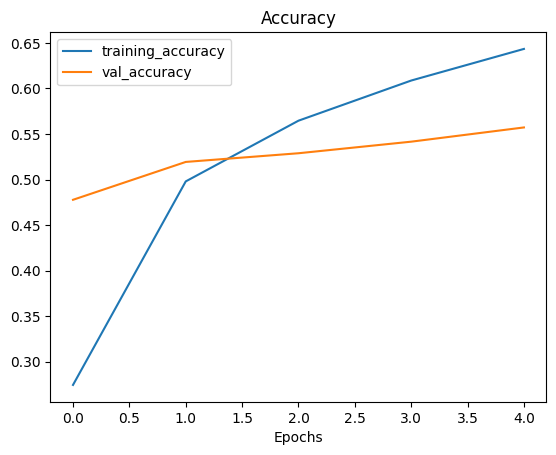

In [19]:
plot_loss_curves(history_all_classes_10_percent)

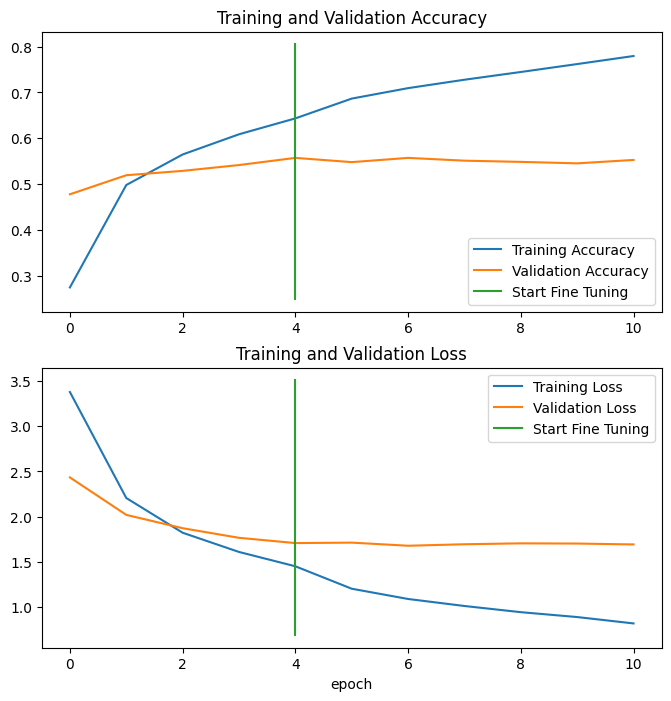

In [20]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

### Save the model

In [21]:
model.save("drive/MyDrive/101_food_classes_10_percent_saved_big_dog_model")

In [22]:
#Load and evaluate the saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/101_food_classes_10_percent_saved_big_dog_model")

In [23]:
#Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 58s 72ms/step - loss: 1.5128 - accuracy: 0.5996


[1.5128308534622192, 0.5996039509773254]

In [24]:
all_classes_10_percent_fine_tune_results

[1.5128308534622192, 0.5996039509773254]

### Evaluating the performance of the big dog model across all different classes

In [25]:
import tensorflow as tf
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-03-24 19:53:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.101.207, 2607:f8b0:4023:c0d::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  72.5MB/s    in 0.6s    

2024-03-24 19:53:06 (72.5 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [26]:
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

In [27]:
# Loading saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [28]:
 #Evaluate loaded model
 results_downloaded_model = model.evaluate(test_data)
 results_downloaded_model

790/790 [==============================] - 60s 74ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

### Make predictions with our model

In [29]:
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 61s 74ms/step


In [30]:
len(preds_probs)

25250

In [31]:
preds_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [32]:
test_data.class_names[52]

'gyoza'

In [33]:
#Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

### Now we've got prediction arrays, now we need to comapre them to the real test data

In [34]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [35]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10] #look at the first 10
# Since the shuffle is off, things aren't in the same order, so need to order them with test label array

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating our model's prediction

In [36]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [37]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred= pred_classes)
sklearn_accuracy

0.6077623762376237

In [38]:
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

### Make a confusion matrix

In [39]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [40]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize=(100,100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [42]:
classification_report_dict=classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

### Displaying the f1 scores

In [43]:
class_f1_scores ={}
for k, v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [44]:
# Turning the f1 scores into a dataframe
import pandas as pd
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                          'f1-score' : list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008


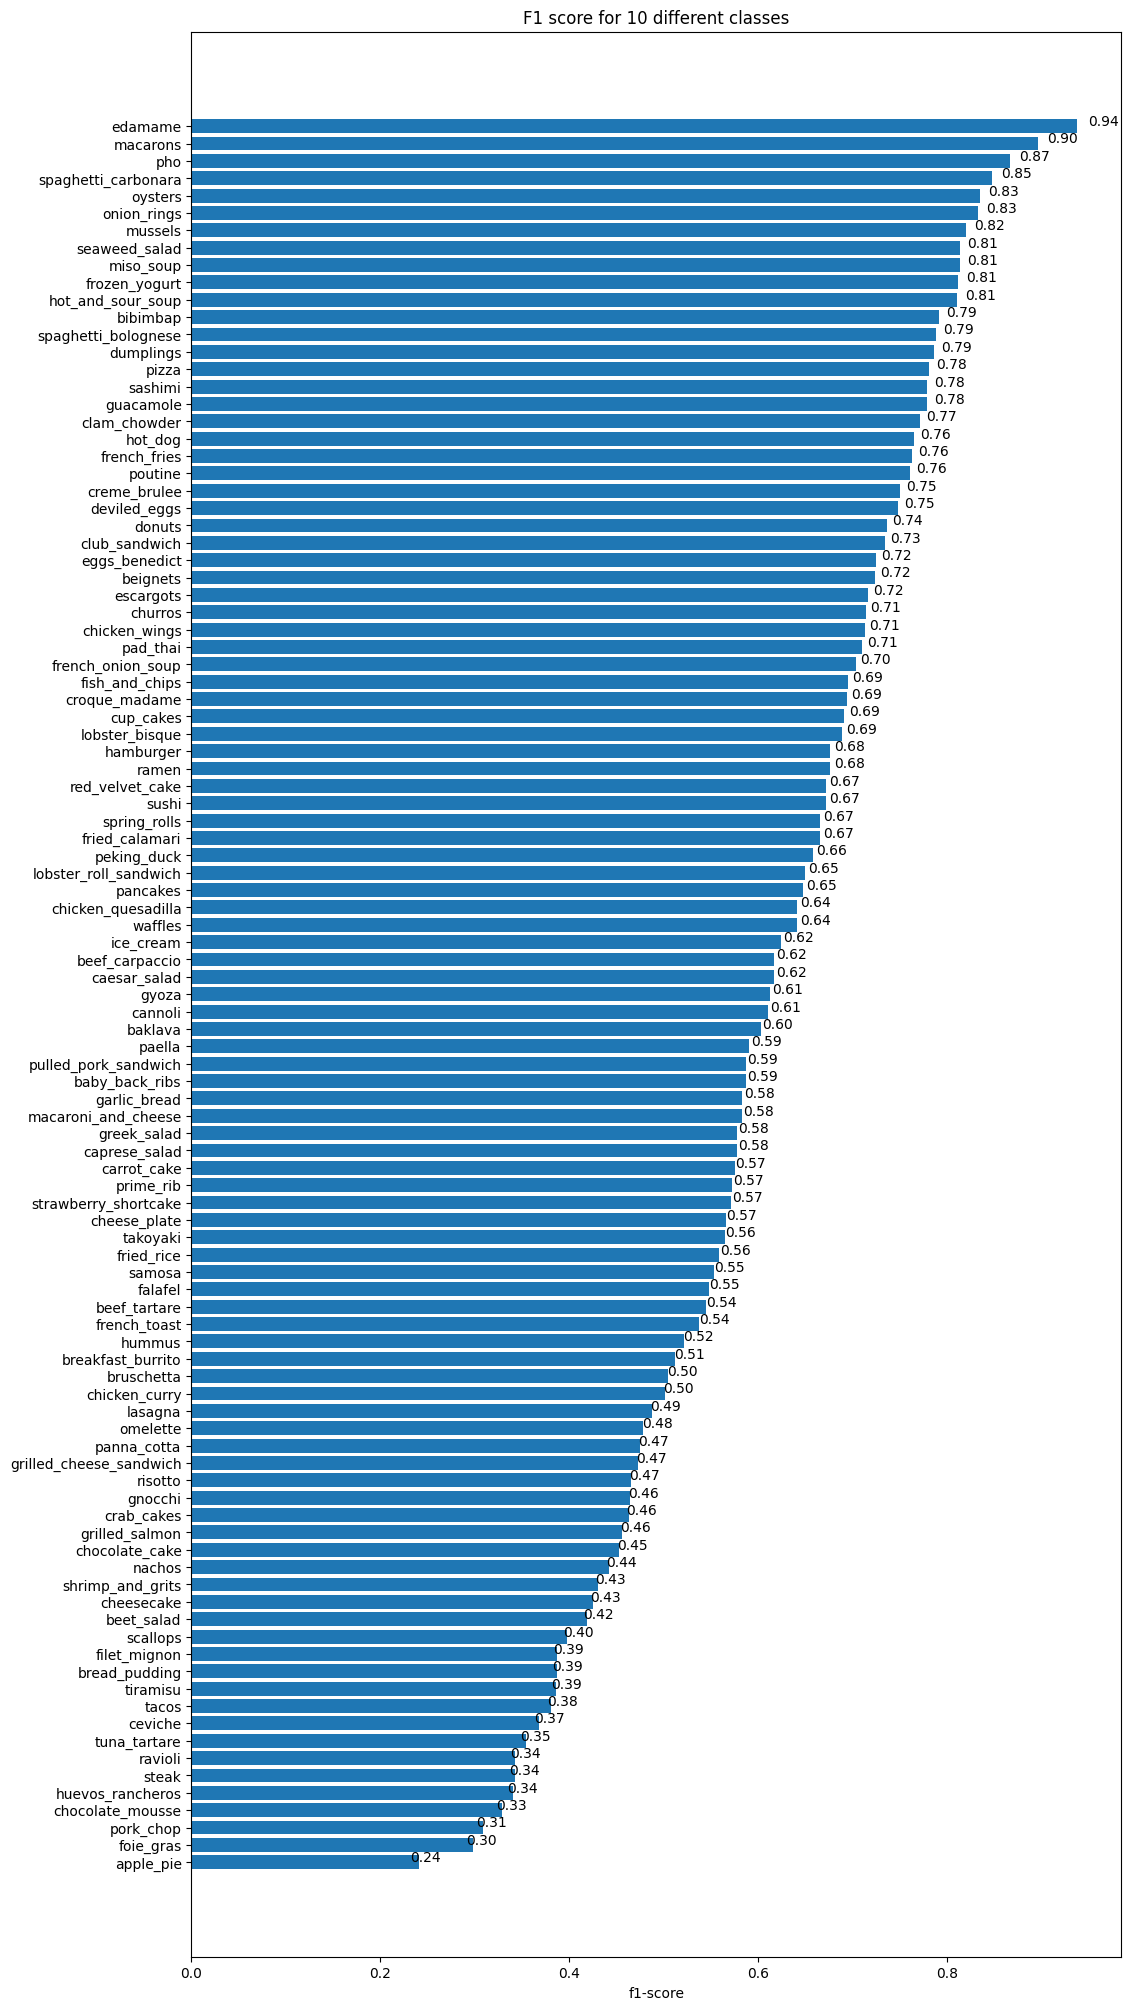

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores['class_names']))
ax.set_xlabel('f1-score')
ax.set_title('F1 score for 10 different classes')
ax.invert_yaxis();

def autolabel(rects):
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Visualizing predictions on custom images

In [46]:
def load_and_prep_image(filename, img_shape=224, scale=True):

  #Read image
  img = tf.io.read_file(filename)

  #Decode in into a tensor
  img = tf.io.decode_image(img)

  #Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    #Rescale the image
    return img/255.
  else:
    return img

1. Load a few random images
2. Make predictions on loaded images
3. Plot the original images along with model predictions, prediction probability and truth label

1/1 [==============================] - 0s 40ms/step


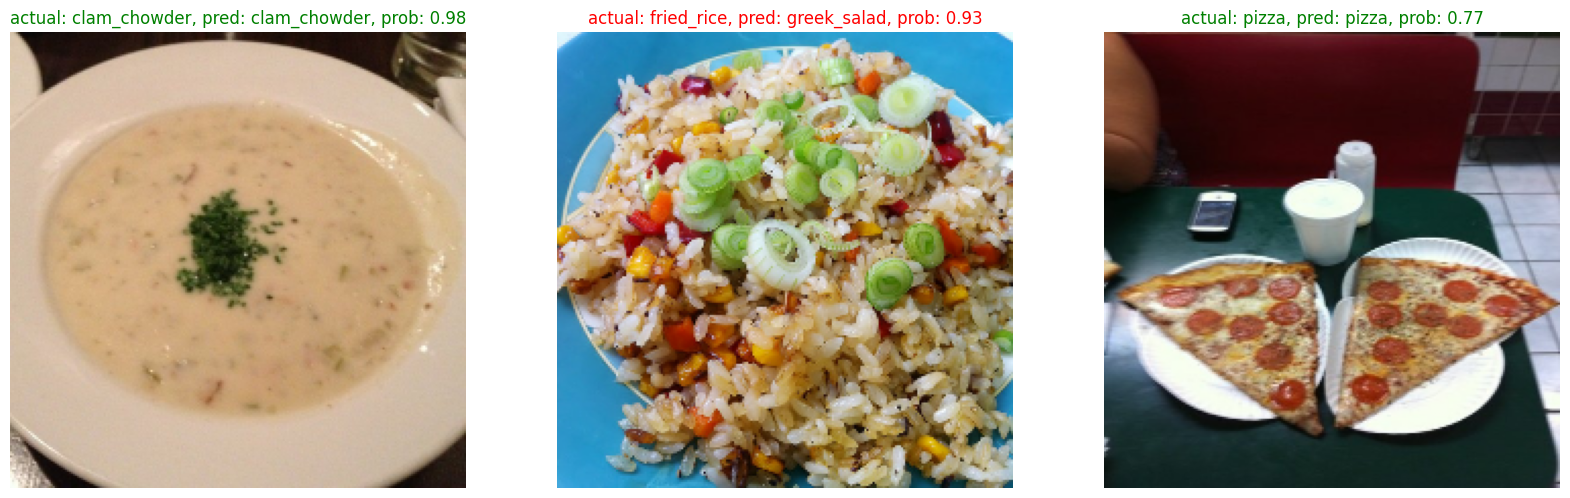

In [51]:
import os
import random

plt.figure(figsize=(20,10))
for i in range(3):
  #Choose a random image from test dataset
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  #load the image and make prediction
  img = load_and_prep_image(filepath, scale=False) #don't scale images for EfficientNet models
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) #model acceps tensors of shape [None, 224, 224, 3], so need to put dimensions in right shape
  pred_class = class_names[pred_prob.argmax()]

  #Plot accordingly
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color='g'
  else:
    title_color='r'
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);